<a href="https://colab.research.google.com/github/juanpajedrez/pytorch_learning/blob/main/04_pytorch_custom_datasets_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets Video Notebook

We've used some datasets with PyTorch before.

But how do you get your own data in PyTorch?

One of the ways to do so it's based on custom datasets.

# Domain libraries

Depending on what you're working on, vision, text, audio, recommendation, you'll want to look into each of the PyTorch domain libraries for existing data loading functions and customizable data loading functions.

**Resources:**
* Book version of the course materials for 04: https://www.learnpytorch.io/00_pytorch_fundamentals/
* Ground truth version of notebook 04: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/04_pytorch_custom_datasets.ipynb

## 0. Importing torch and device agnostic code


In [1]:
import torch
from torch import nn

# Note: PyTorch 1.10.0 + is required for this course
torch.__version__

'2.6.0+cu124'

In [2]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
!nvidia-smi

Wed Apr 30 20:56:02 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   56C    P8             11W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 1. Get data

Our dataset is a subset of the Food101 dataset.

Food101 starts with 101 different classes of food and 1000 images per class (750 training, 250 testing).

Our dataset starts with 3 classes of food and only 10% of the images (75 training, 25 testing).

Why do this?

When starting out ML projects, it's important to try things on a small scale, and then increase the scale when necessary.

The whole point is to speed up how fast you can experiment.

In [4]:
import requests
import zipfile
from pathlib import Path

# Setup a path to a data folder
data_path = Path("data")
image_path = data_path.joinpath("pizza_steak_sushi")

#If the image folder doesn't exist, download it and prepare it
if image_path.is_dir():
  print(f"{image_path} directory already exists... skipping download")
else:
  print(f"{image_path} does not exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak and sushi data
with open(data_path.joinpath("pizza_steak_sushi.zip"), "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip")
  print(f"Downloading pizza, steak and sushi data...")
  f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path.joinpath("pizza_steak_sushi.zip"), "r") as zip_ref:
  print("Unzipping pizza, steak, and sushi data...")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi does not exist, creating one...
Unzipping pizza, steak, and sushi data...


## 2. Becoming one with the data (data preparation and data exploration).

In [5]:
import os
def walk_through_dir(dir_path):
  '''
  Walks through dir_path returning its contents
  '''
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"Theare are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'")

In [6]:
walk_through_dir(image_path)

Theare are 2 directories and 0 images in 'data/pizza_steak_sushi'
Theare are 3 directories and 0 images in 'data/pizza_steak_sushi/train'
Theare are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'
Theare are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'
Theare are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'
Theare are 3 directories and 0 images in 'data/pizza_steak_sushi/test'
Theare are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'
Theare are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'
Theare are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'


In [7]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing an image

Let's write some code to:
1. Get all of the image paths.
2. Pick a random image path using Python's random.choice()
3. Get the image class name using `pathlib.Path.parent.stem`
4. Since we're working with images, let's open the image with Python PIL.
5. We'll then show the image and print metadata.

Random image path: data/pizza_steak_sushi/train/steak/1736968.jpg
Image class: steak
Image height: 512
Image width: 512


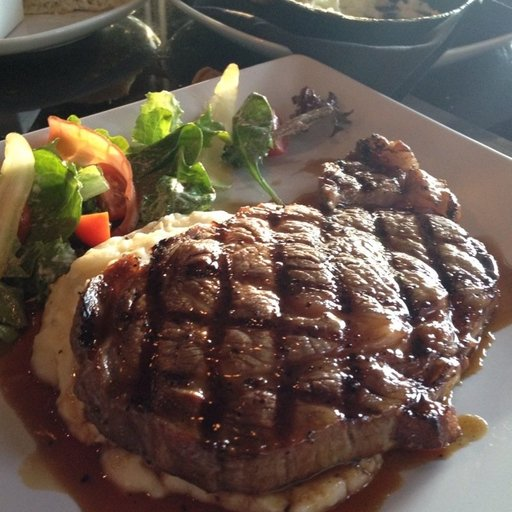

In [8]:
import random
from PIL import Image

# Set seed
#random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

(np.float64(-0.5), np.float64(511.5), np.float64(511.5), np.float64(-0.5))

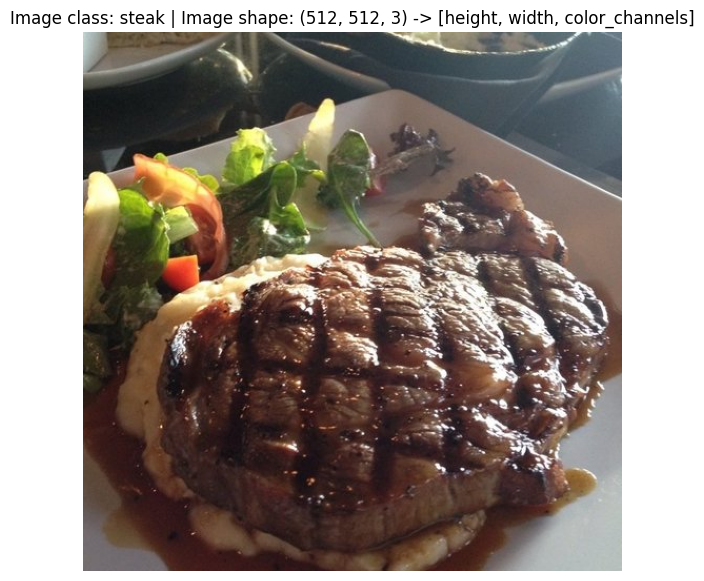

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the imag with matplotlib
plt.figure(figsize = (10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis("off")

array([[[200, 216, 213],
        [192, 208, 205],
        [187, 201, 201],
        ...,
        [106, 124, 136],
        [105, 123, 135],
        [103, 121, 133]],

       [[197, 213, 210],
        [192, 208, 205],
        [187, 201, 201],
        ...,
        [106, 124, 136],
        [103, 121, 133],
        [100, 118, 130]],

       [[197, 213, 210],
        [195, 211, 208],
        [189, 205, 204],
        ...,
        [102, 120, 132],
        [107, 125, 137],
        [110, 128, 140]],

       ...,

       [[117, 111, 113],
        [115, 109, 111],
        [115, 109, 111],
        ...,
        [182, 191, 188],
        [182, 191, 188],
        [182, 191, 188]],

       [[116, 110, 112],
        [115, 109, 111],
        [116, 110, 112],
        ...,
        [180, 189, 186],
        [180, 189, 186],
        [181, 190, 187]],

       [[115, 109, 111],
        [115, 109, 111],
        [117, 111, 113],
        ...,
        [185, 194, 191],
        [186, 195, 192],
        [187, 196, 193]]], dtype=uint8)
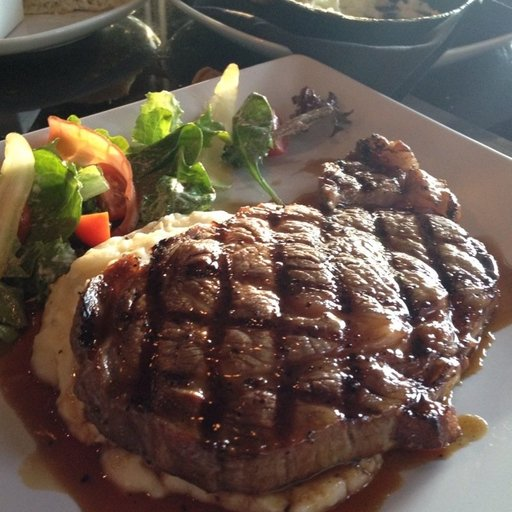

In [10]:
img_as_array

## 3. Transforming data

Before we can use our image data with PyTorch:
1. Turn your target data into tensors (in our case, numerical representation of our images).
2. Turn it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader`.

In [11]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

Transforms help you get your images ready to be used with a model/perform data augemntation: - https://pytorch.org/vision/0.9/transforms.html

In [12]:
# Write a transform for image
data_transform = transforms.Compose([
    # Resize our images to 64x64
    transforms.Resize(size = (64, 64)),
    # Flip the images randomly on the horizonal
    transforms.RandomHorizontalFlip(p = 0.5),
    # Turn image into a torch.tensor()
    transforms.ToTensor()
])

In [13]:
def plot_transformed_images(image_paths: list, transform, n = 3, seed = 42):
  '''
  Selects random images from a path of images and loads/transforms them then plots
  the original vs the transformed version.
  '''
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows = 1, ncols = 2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis("off")

      # Transform and plot target image.
      transformed_image = transform(f).permute(1, 2, 0) # note we would need to change shape for matplotlib
      # We changed the order of the dimensions from (C, H, W) -> (H, W, C)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize = 16)

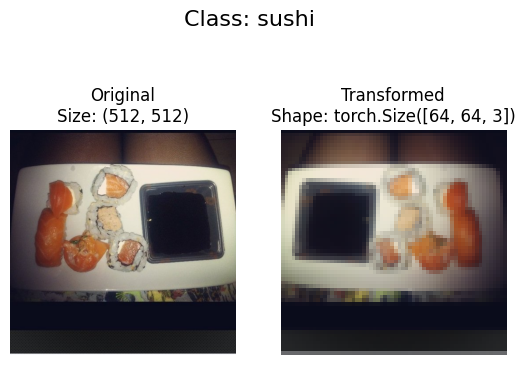

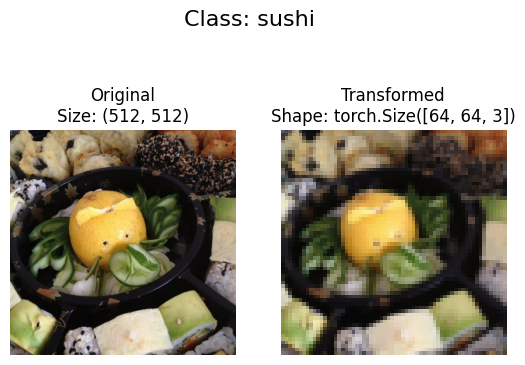

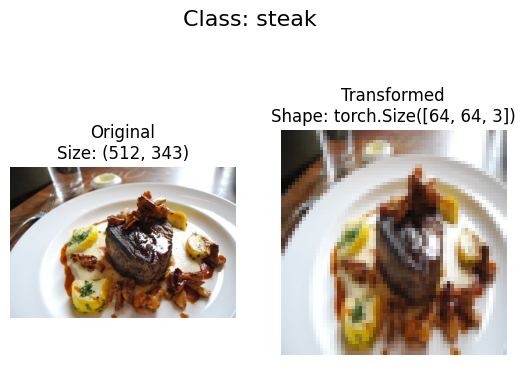

In [14]:
plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n = 3,
                        seed = 42)

## 4. Option 1: Loading image data using `ImageFolder`

We can load image classification data using `torchvision.datasets.ImageFolder` -
https://pytorch.org/vision/main/generated/torchvision.datasets.ImageFolder.html


In [15]:
# Use ImageFolder to create datasets:
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # A transform for the data
                                  target_transform=None) # A transform for the label/target

test_data = datasets.ImageFolder(root = test_dir,
                                 transform = data_transform,
                                 target_transform= None)

# Print the datasets
train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [16]:
train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

In [17]:
# Get class names as a list
class_names = train_data.classes

In [18]:
# Get class names as dcit
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [19]:
# Check the lengths of our dataset
len(train_data), len(test_data)

(225, 75)

In [20]:
import random
#random.seed(42)
# Index on the train_data Dataset to get a single image and label

rand_idx = random.randint(0, len(train_data) - 1)
img, label = train_data[rand_idx]
print(f"Image tensor:{img}")
print(f"Image shape:{img.shape}")
print(f"Image datatype:{img.dtype}")
print(f"Image device:{img.device}")

#Print the label information
print(f"Image label:{label} {class_names[label]}")
print(f"Image label datatype: {type(label)}")

Image tensor:tensor([[[0.4667, 0.4745, 0.5176,  ..., 0.2039, 0.2157, 0.2039],
         [0.4392, 0.4392, 0.4353,  ..., 0.2078, 0.1843, 0.1804],
         [0.4275, 0.3961, 0.3216,  ..., 0.2157, 0.1961, 0.1804],
         ...,
         [0.3412, 0.3216, 0.4078,  ..., 0.6196, 0.6392, 0.6078],
         [0.3333, 0.3412, 0.3725,  ..., 0.5804, 0.6196, 0.6039],
         [0.3608, 0.3804, 0.3843,  ..., 0.5373, 0.5922, 0.6078]],

        [[0.3373, 0.4471, 0.5294,  ..., 0.2196, 0.2784, 0.2471],
         [0.1843, 0.2118, 0.2392,  ..., 0.2078, 0.1961, 0.1961],
         [0.1490, 0.1294, 0.1961,  ..., 0.2118, 0.2039, 0.2157],
         ...,
         [0.3882, 0.3529, 0.4196,  ..., 0.6627, 0.7059, 0.6353],
         [0.3843, 0.3882, 0.3922,  ..., 0.5843, 0.6824, 0.6549],
         [0.4431, 0.4549, 0.4510,  ..., 0.5137, 0.6471, 0.6784]],

        [[0.5176, 0.6549, 0.7255,  ..., 0.2941, 0.3608, 0.3373],
         [0.3059, 0.3490, 0.4157,  ..., 0.2784, 0.2706, 0.2784],
         [0.2667, 0.2510, 0.3686,  ..., 0.286

In [21]:
class_names[label]

'pizza'

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Permuted shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


Text(0.5, 1.0, 'Image class: pizza')

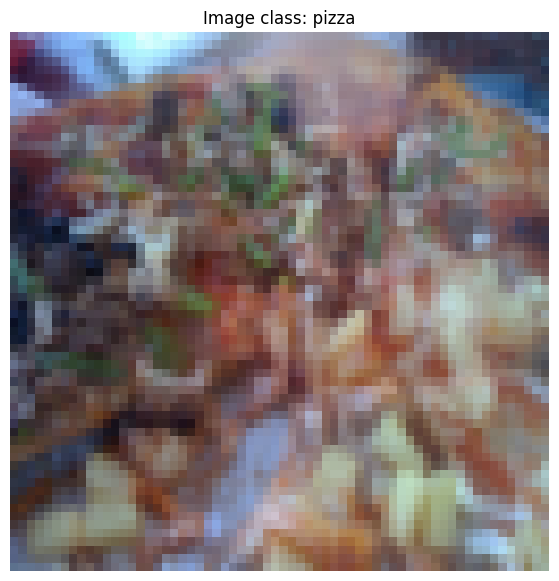

In [22]:
img_permute = img.permute(1, 2, 0)

#Print out the original and permuted shapes
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Permuted shape: {img_permute.shape} -> [height, width, color_channels]")

#Plot the image
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.axis("off")
plt.title(f"Image class: {class_names[label]}")


## 4.1 Turn loaded images into ~`DataLoader`'s

A `DataLoader` is going to help us tur our `Dataset`'s into iteravles and we can customise the `batch_size` so our model can see `batch_size` images at a time.

In [23]:
!nvidia-smi

Wed Apr 30 20:56:19 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   56C    P8             10W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [24]:
import os
os.cpu_count()

2

In [25]:
# Turn train and test datasets into DataLoader's
from torch.utils.data import DataLoader
BATCH_SIZE = 1
train_dataloader = DataLoader(
    dataset = train_data,
    batch_size = BATCH_SIZE,
    num_workers = os.cpu_count(),
    shuffle = True
)

test_dataloader = DataLoader(
    dataset = test_data,
    batch_size= BATCH_SIZE,
    num_workers = os.cpu_count(),
    shuffle = False
)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7b1662428e90>,
 <torch.utils.data.dataloader.DataLoader at 0x7b16623b7d90>)

In [26]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [27]:
img, label = next(iter(train_dataloader))

# Batch size will be now 1, you can change the batch size if you like
print(f"Image shape: {img.shape} -> [batch_size, colour_channels, height, width]")
print(f"label shale: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, colour_channels, height, width]
label shale: torch.Size([1])


## 5 Option 2: Loading Image Data with a Custom `Dataset`

1. Want to be able to load images from file
2. Want to be able to get class names from the Dataset
3. Want to be able to get classes as dictionary from the dataset.

Pros:
* Can create a `Dataset` out of almost anything
* Not limited to PyTorch pre-built `Dataset` functions

Cons:
* Even thought you could create `Dataset` out of almost anything, it doesnt mean it will work....
* Using a custom `Dataset` often results in us writing more code, which could be prone to errors or performance issues.

All custom datasets in PyTorch, often subclass -https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset


In [28]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [29]:
# Instace of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

## 5.1 Creating a helper funciton to get class names

We want a function to:
1. Get the class names using `os.scandir()` to traverse a target directory (ideally the directory is in the standard image classification format).
2. Raise an error if the class names aren't found (if this happens, there might be something with the directory structure).
3. Turn the class names into a dict and a list and return them.

In [30]:
# Setip path for target directory
target_directory = train_dir
print(f"Target directory: {target_directory}")

Target directory: data/pizza_steak_sushi/train


In [31]:
# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

['pizza', 'steak', 'sushi']

In [32]:
list(os.scandir(target_directory))

[<DirEntry 'sushi'>, <DirEntry 'steak'>, <DirEntry 'pizza'>]

In [33]:
def find_classses(directory: str) -> Tuple[List[str], Dict[str, int]]:
  '''
  Finds the class folder names in a target directory
  '''
  # 1 Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise an error if class name scould not be found
  if not classes:
    raise FileNotFoundError(f"Couldnt find any classes in {directory}, please check file structure")

  #3. Crete a dictionary of index labels (computer prefer numbers rather than strings as labels)
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
  return classes, class_to_idx

In [34]:
find_classses(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

To create our own custom dataset, we want to:

1. Subclass `torch.utils.Dataset`
2. Init our subclass with a target directory (the directory we'd like to get data from) as well as a transform if we'd like to transform our data.
3. Create several attributes:
  * paths - paths of our images
  * transform - the transform we'd like to use.
  * classes -  a list of the target classes.
  * class_to_idx - a dict of the target classes mapped to interger labels.
4. Create a function to `load_images()`, this function will open an image.
5. Overwrite the `__len__()` method to return the length of our dataset
6. Overwrite the `__getitem()__` method to return a given sample when passed an index.

In [35]:
#0. Write a custom dataset class
from torch.utils.data import Dataset

#1. Subsclass torch.utls.data.Dataset
class ImageFolderCustom(Dataset):
  #2. Initialize our custom Dataset
  def __init__(self, target_dir:str, transform = None):
    super().__init__()
    #3. Create class attributes
    #Get all of the image paths
    self.paths = list(pathlib.Path(target_dir).glob("*/*.jpg"))
    #Setup transforms
    self.transform = transform
    #Create classes and class_to_idx attributes
    self.classes, self.class_to_idx = find_classses(directory=target_dir)

  #4. Create a function to load images
  def load_image(self, idx) -> Image.Image:
    '''
    Opens an image by index and returns it.
    '''
    image_path = self.paths[idx]
    return Image.open(image_path)

  #5. Overwrite __len__()
  def __len__(self) -> int:
    '''
    Returns the total number of samples
    '''
    return len(self.paths)

  #6. Overwrite _-getitem__() to return a particular sample
  def __getitem__(self, index:int) -> Tuple[torch.Tensor, int]:
    '''
    Returns one sample of data, data and label (X, y)
    '''
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpeg
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx
    else:
      return img, class_idx

In [36]:
#Lets see the types of the original dataset
img, label = train_data[0]

print(f"Image tensor:{img}")
print(f"Image shape:{img.shape}")
print(f"Image datatype:{img.dtype}")
print(f"Image device:{img.device}")

#Print the label information
print(f"Image label:{label} {class_names[label]}")
print(f"Image label datatype: {type(label)}")

Image tensor:tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.015

In [37]:
# Create a transform
train_transforms = transforms.Compose(
    [transforms.Resize(size = (64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()]
)

test_transforms = transforms.Compose(
    [transforms.Resize(size = (64, 64)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()]
)

In [38]:
# Test out ImageFolderCustom
train_data_custom = ImageFolderCustom(target_dir = train_dir, transform = train_transforms)
test_data_custom = ImageFolderCustom(target_dir = test_dir, transform = test_transforms)

In [39]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [40]:
len(train_data), len(test_data)

(225, 75)

In [41]:
train_data_custom.classes, train_data_custom.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

In [42]:
# Check for equality between original ImageFolder Dataset and ImageFolderCustomDataset
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True


### 5.3 Create a function to display random images
1. Take in a `Dataset` and a number of other parameters such as class names and how many images to visualize.
2. To precent the display getting out of hand, let's cap the number of images to see at 10.
3. Set a random seed for reproducibility
4. Get a list of random samples indexes from the target dataset.
5. Setup a matplotlib plot.
6. Loop through the random sample indices and plot them with matplotlib.
7. Make sure the dimensions of our images line up with matplotlib (HWC).

In [43]:
# 1. Create a function to take in a dataset:
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape:bool = True,
                          seed:int = None):
  # 2. Adjust display if n is too high
  if n >= 10:
    n = 10
    display_shape = False
    print(f"n should be less than 10, setting display_shape = {display_shape}")

  # 3. Set the seed
  if seed:
    random.seed(seed)

  # 4 Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k = n)

  # 5 Setup plot
  plt.figure(figsize=(16, 8))

  # 6 Loop through random indexes, and plot them with matplotlib
  for i, target_sample in enumerate(random_samples_idx):
    targ_image, targ_label = dataset[target_sample][0], dataset[target_sample][1]
    # Adjust the display shape

    # 7 Adjust tensor dimensions to plot them properly
    targ_img_adjust = targ_image.permute(1, 2, 0) # [colour_channels, height, width] -> [height, width, colour_channels]

    # Plot adjusted samples
    plt.subplot(1, n, i + 1)
    plt.imshow(targ_img_adjust)
    plt.axis("off")
    if classes:
      title = f"Class: {classes[targ_label]}"
      if display_shape:
        title = title + f" \n| Shape: {targ_image.shape}"
      plt.title(title)

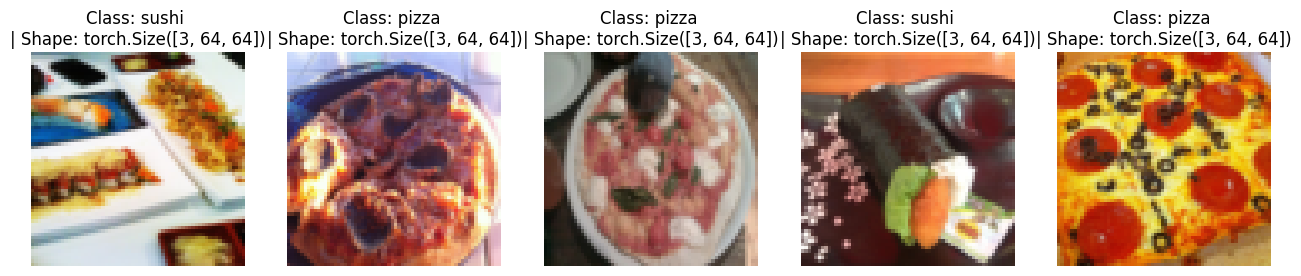

In [44]:
# Display random images from training folder
display_random_images(dataset = train_data,
                      classes = train_data.classes,
                      n = 5,
                      seed = 42)

n should be less than 10, setting display_shape = False


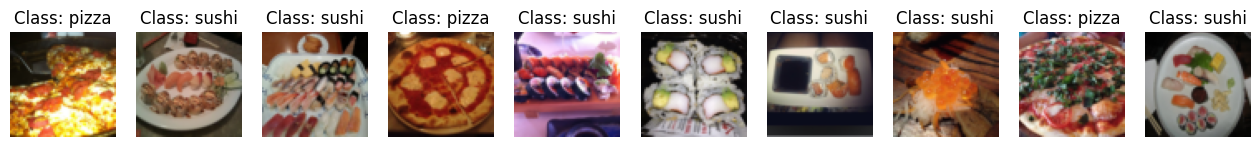

In [45]:
# Display random images from ImageFolderCustom Dataset
display_random_images(dataset = train_data_custom,
                      classes = train_data_custom.classes,
                      n = 10,
                      seed = 42)

### 5.4 Turn custom loaded images into `Dataloader`'s

In [46]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
train_dataloader_custom = DataLoader(dataset=train_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)

test_dataloader_custom = DataLoader(dataset=test_data_custom,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=False)

In [47]:
train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7b166192b110>,
 <torch.utils.data.dataloader.DataLoader at 0x7b1661a20610>)

In [48]:
# Get image and label from custom dataloader
img_custom, label_custom = next(iter(train_dataloader_custom))

#Print out the shape of all
img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 6. Other forms of transforms (data augmentation)

Data augmentation is the process of artificially adding diversity to your training data.

In the case of image data, this may mean applying various image transformations to the training images.

This practice hopefully results in a model that's more generalizable to: https://pytorch.org/blog/how-to-train-state-of-the-art-models-using-torchvision-latest-primitives/

Let's take a look at one particualtes one type of data augmentation used to train PyTorch vision models to state of the art levels....

In [49]:
# Lets look at trivilaugment
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize(size = (224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.Resize(size = (224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

In [50]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list[:10]

[PosixPath('data/pizza_steak_sushi/train/sushi/169392.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/748830.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/3360232.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/855721.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/2797464.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/2720223.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/3107839.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/1138695.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/1552504.jpg'),
 PosixPath('data/pizza_steak_sushi/train/sushi/307738.jpg')]

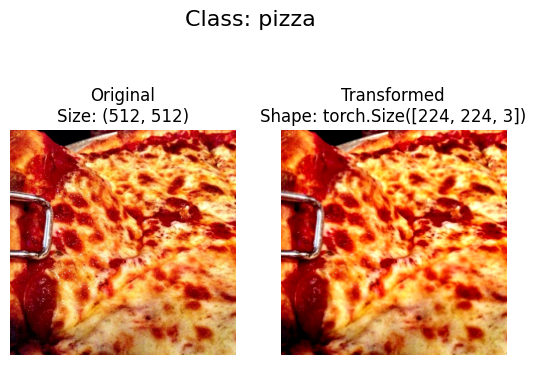

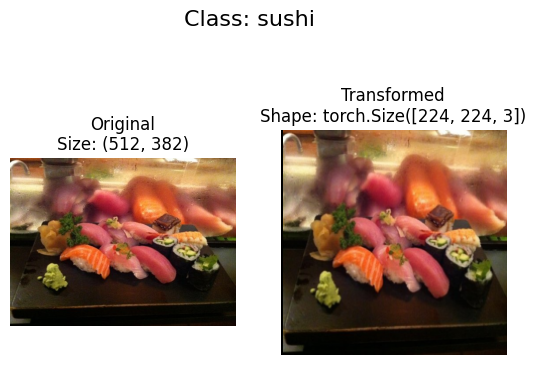

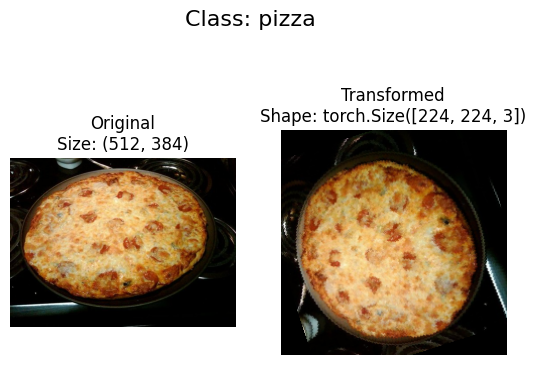

In [51]:
# Plot random transformed images
plot_transformed_images(image_paths=image_path_list,
                        transform=train_transform,
                        n = 3,
                        seed = None)

## 7. Model 0: TinyVGG without data augmentation.

Let's replicate TinyVGG architecture from the CNN Explainer website: https://poloclub.github.io/cnn-explainer/

### 7.1 Creating transforms and loading data for Model 0

In [52]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize(size = (64, 64)),
    transforms.ToTensor()
])

In [53]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(
    root = train_dir,
    transform = simple_transform)
test_data_simple = datasets.ImageFolder(
    root = test_dir,
    transform = simple_transform)

# 2. Turn the datasets into DataLoaders
import os
from torch.utils.data import DataLoader

#Setup batch size and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

#Create the DataLoader's
train_dataloader_simple = DataLoader(dataset = train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset = test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    shuffle=False,
                                    num_workers=NUM_WORKERS)

In [54]:
NUM_WORKERS

2

### 7.2 Create TinyVGG model class

In [55]:
class TinyVGG(nn.Module):
  '''
  Model Architecture copying TinyVGG from CNN Explainer website: https://poloclub.github.io/cnn-explainer/
  '''
  def __init__(self, input_shape:int,
               hidden_units:int,
               output_shape:int) -> None:
    super().__init__()

    # Create block 1 of the tiny VGG
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )

    # Create block 2 of the tiny_vgg
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )

    # Create a classifier layer
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(
            in_features = hidden_units*13*13,
            out_features=output_shape
        )
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    #print(x.shape)
    x = self.conv_block_2(x)
    #print(x.shape)
    x = self.classifier(x)
    #print(x.shape)
    return x

In [56]:
torch.manual_seed(42)
model_0 = TinyVGG(input_shape = 3 , #Number of colour channels in our image data
                  hidden_units = 10,
                  output_shape=len(class_names)).to(device)

model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1690, out_features=3, bias=True)
  )
)

### 7.3 Try a forward pass in a single image (to test the model)

In [57]:
# Get a single image batch
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [58]:
# Try a forward pass
model_0(image_batch.to(device))

tensor([[ 2.0795e-02, -1.9510e-03,  9.5212e-03],
        [ 1.8440e-02,  2.4669e-03,  6.6609e-03],
        [ 1.7695e-02,  1.0282e-03,  9.4975e-03],
        [ 2.4446e-02, -3.3489e-03,  9.5877e-03],
        [ 1.9939e-02,  6.9129e-04,  1.0778e-02],
        [ 2.1281e-02,  2.0434e-03,  5.0046e-03],
        [ 2.0996e-02,  1.6417e-04,  1.2481e-02],
        [ 2.1566e-02, -1.9607e-03,  9.7175e-03],
        [ 2.4500e-02, -4.7904e-03,  8.5394e-03],
        [ 2.0239e-02, -4.7980e-04,  1.0907e-02],
        [ 2.2219e-02, -4.1815e-04,  9.8173e-03],
        [ 2.2318e-02, -2.1642e-03,  9.4428e-03],
        [ 2.1851e-02, -3.7225e-03,  8.3784e-03],
        [ 2.2881e-02, -1.7559e-03,  1.0299e-02],
        [ 2.1635e-02, -4.3994e-03,  9.4990e-03],
        [ 2.2101e-02, -4.1469e-03,  9.3904e-03],
        [ 2.1226e-02, -4.4215e-03,  1.1476e-02],
        [ 2.1698e-02, -2.7458e-03,  8.4966e-03],
        [ 1.9974e-02, -3.2317e-07,  8.4496e-03],
        [ 1.8308e-02,  1.6378e-03,  8.5491e-03],
        [ 2.0768e-02

### 7.4 Use `torchinfo` to get an idea of the shapes going through the model.#

In [59]:
# Install torch info, import it if its available
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary
summary(model_0, input_size=(1, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

## 7.5 Create train and test loops functions

* `train_step()` - takes in a model and dataloader and trains the model on the dataloader.

* `test_step()` - takes in a model and dataloader and evaluates the model on the dataloader.

In [60]:
# Create train_step()
def train_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device = device):
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy
  train_loss, train_acc = 0, 0

  # Loop through our data loader data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to target device
    X = X.to(device)
    y = y.to(device)

    # 1. Forward pass
    y_pred = model(X) # output model logits

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Step backwards
    loss.backward()

    # 5 Optimizer step
    optimizer.step()

    # Calculate the accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Average out per batch
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)
  return train_loss, train_acc

In [61]:
# Create a test step
def test_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               device = device):
  # Put the model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # turn on inference mode
  with torch.inference_mode():
    # Lopp through the data loader
    for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X = X.to(device)
      y = y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X) # output model logits

      # 2. Calculate the loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate the accuracy metric
      test_pred_labels = torch.argmax(torch.softmax(test_pred_logits, dim=1), dim=1)
      test_acc += (test_pred_labels == y).sum().item()/len(test_pred_logits)

  # Average out per batch
  test_loss /= len(dataloader)
  test_acc /= len(dataloader)
  return test_loss, test_acc

### 7.6 Creating a `train()` function to combine `train_step()` and `test_step()`.

In [62]:
from tqdm import tqdm

# 1. Create a train function that takes in various model parameters + optimizer + dataloader + ...
def train(model:torch.nn.Module,
          train_dataloader:torch.utils.data.DataLoader,
          test_dataloader:torch.utils.data.DataLoader,
          optimizer:torch.optim.Optimizer,
          loss_fn:torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device = device):

  # 2 Create empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # 3. Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model = model,
                                       dataloader = train_dataloader,
                                       loss_fn = loss_fn,
                                       optimizer = optimizer,
                                       device = device)
    test_loss, test_acc = test_step(model = model,
                                    dataloader = test_dataloader,
                                    loss_fn = loss_fn,
                                    device = device)

    # 4 Print out whats happening
    print(f"Epoch: {epoch} | train_loss: {train_loss:.4f} | train_acc: {train_acc:.4f} | test_loss: {test_loss:.4f} | test_acc: {test_acc:.4f}")

    # 5. Update our results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # 6 Return the filled results at the end of the epochs
  return results

## 7.7 Train and evaluate the model

In [63]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
NUM_EPOCHS = 20

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape = 3, # Number of colour channels in the target images,
                  hidden_units = 10,
                  output_shape = len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model_0.parameters(), lr = 0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model = model_0,
                        train_dataloader = train_dataloader_simple,
                        test_dataloader = test_dataloader_simple,
                        optimizer = optimizer,
                        loss_fn = loss_fn,
                        epochs = NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time - start_time:.3f} seconds")

  5%|▌         | 1/20 [00:02<00:44,  2.35s/it]

Epoch: 0 | train_loss: 1.1063 | train_acc: 0.3047 | test_loss: 1.0983 | test_acc: 0.3011


 10%|█         | 2/20 [00:03<00:31,  1.75s/it]

Epoch: 1 | train_loss: 1.0998 | train_acc: 0.3281 | test_loss: 1.0697 | test_acc: 0.5417


 15%|█▌        | 3/20 [00:04<00:24,  1.44s/it]

Epoch: 2 | train_loss: 1.0869 | train_acc: 0.4883 | test_loss: 1.0808 | test_acc: 0.4924


 20%|██        | 4/20 [00:06<00:23,  1.46s/it]

Epoch: 3 | train_loss: 1.0845 | train_acc: 0.4023 | test_loss: 1.0607 | test_acc: 0.5833


 25%|██▌       | 5/20 [00:08<00:27,  1.86s/it]

Epoch: 4 | train_loss: 1.0663 | train_acc: 0.4219 | test_loss: 1.0656 | test_acc: 0.5644


 30%|███       | 6/20 [00:10<00:25,  1.84s/it]

Epoch: 5 | train_loss: 1.0305 | train_acc: 0.4375 | test_loss: 1.0137 | test_acc: 0.5426


 35%|███▌      | 7/20 [00:12<00:22,  1.72s/it]

Epoch: 6 | train_loss: 0.9825 | train_acc: 0.4180 | test_loss: 0.9310 | test_acc: 0.5938


 40%|████      | 8/20 [00:13<00:21,  1.77s/it]

Epoch: 7 | train_loss: 0.9495 | train_acc: 0.5859 | test_loss: 1.0140 | test_acc: 0.4744


 45%|████▌     | 9/20 [00:15<00:18,  1.73s/it]

Epoch: 8 | train_loss: 0.9164 | train_acc: 0.6055 | test_loss: 1.0703 | test_acc: 0.3428


 50%|█████     | 10/20 [00:17<00:17,  1.72s/it]

Epoch: 9 | train_loss: 0.9969 | train_acc: 0.4648 | test_loss: 1.0464 | test_acc: 0.3939


 55%|█████▌    | 11/20 [00:19<00:16,  1.81s/it]

Epoch: 10 | train_loss: 0.8577 | train_acc: 0.5234 | test_loss: 0.9810 | test_acc: 0.5237


 60%|██████    | 12/20 [00:21<00:16,  2.03s/it]

Epoch: 11 | train_loss: 0.9286 | train_acc: 0.4414 | test_loss: 0.9399 | test_acc: 0.5653


 65%|██████▌   | 13/20 [00:22<00:12,  1.74s/it]

Epoch: 12 | train_loss: 0.7849 | train_acc: 0.6484 | test_loss: 1.0025 | test_acc: 0.4129


 70%|███████   | 14/20 [00:23<00:08,  1.48s/it]

Epoch: 13 | train_loss: 0.9060 | train_acc: 0.5352 | test_loss: 1.0624 | test_acc: 0.4848


 75%|███████▌  | 15/20 [00:24<00:06,  1.31s/it]

Epoch: 14 | train_loss: 0.7789 | train_acc: 0.7070 | test_loss: 0.9973 | test_acc: 0.5246


 80%|████████  | 16/20 [00:25<00:04,  1.18s/it]

Epoch: 15 | train_loss: 0.7417 | train_acc: 0.6719 | test_loss: 1.0052 | test_acc: 0.5038


 85%|████████▌ | 17/20 [00:26<00:03,  1.19s/it]

Epoch: 16 | train_loss: 0.7638 | train_acc: 0.7148 | test_loss: 1.0334 | test_acc: 0.4640


 90%|█████████ | 18/20 [00:27<00:02,  1.10s/it]

Epoch: 17 | train_loss: 0.7381 | train_acc: 0.6562 | test_loss: 1.0716 | test_acc: 0.4337


 95%|█████████▌| 19/20 [00:28<00:01,  1.04s/it]

Epoch: 18 | train_loss: 0.7519 | train_acc: 0.7188 | test_loss: 1.0525 | test_acc: 0.5152


100%|██████████| 20/20 [00:29<00:00,  1.47s/it]

Epoch: 19 | train_loss: 0.7520 | train_acc: 0.6484 | test_loss: 1.0770 | test_acc: 0.4545
Total training time: 29.465 seconds


In [64]:
model_0_results

{'train_loss': [1.1063193529844284,
  1.0997829586267471,
  1.0869046300649643,
  1.0844947695732117,
  1.0663247555494308,
  1.0304641351103783,
  0.9825448840856552,
  0.9495015069842339,
  0.916444681584835,
  0.9969063848257065,
  0.8577160462737083,
  0.928567685186863,
  0.7848574705421925,
  0.9060329720377922,
  0.7788847014307976,
  0.7416571900248528,
  0.7637796625494957,
  0.7380504049360752,
  0.7519012093544006,
  0.7520481869578362],
 'train_acc': [0.3046875,
  0.328125,
  0.48828125,
  0.40234375,
  0.421875,
  0.4375,
  0.41796875,
  0.5859375,
  0.60546875,
  0.46484375,
  0.5234375,
  0.44140625,
  0.6484375,
  0.53515625,
  0.70703125,
  0.671875,
  0.71484375,
  0.65625,
  0.71875,
  0.6484375],
 'test_loss': [1.0983217159907024,
  1.069722851117452,
  1.0808205207188923,
  1.0607157548268635,
  1.065643350283305,
  1.0136977831522624,
  0.9309839208920797,
  1.013972560564677,
  1.070276955763499,
  1.0463884274164836,
  0.9810001850128174,
  0.9398609002431234,
 

### 7.8 Plot the loss curves of Model 0

A **loss curve** is a way of tracking your model's progress over time.

In [65]:
# Get the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [66]:
def plot_loss_curves(results: Dict[str, List[float]]):
  '''
  Plots training curves of a results dictionary.
  '''
  # Get the loss values of the results dictionary (training and test)
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # Get the accuracy values of the results dictionary (training and test)
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  #Figure out how many epochs there were
  epochs = range(len(results["train_loss"]))

  #Setup a plot
  plt.figure(figsize = (15, 7))

  #Plot the loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label = "train_loss")
  plt.plot(epochs, test_loss, label = "test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend(loc = "upper right")

  #Plot the accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label = "train_accuracy")
  plt.plot(epochs, test_accuracy, label = "test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend(loc = "upper right")
  plt.show()


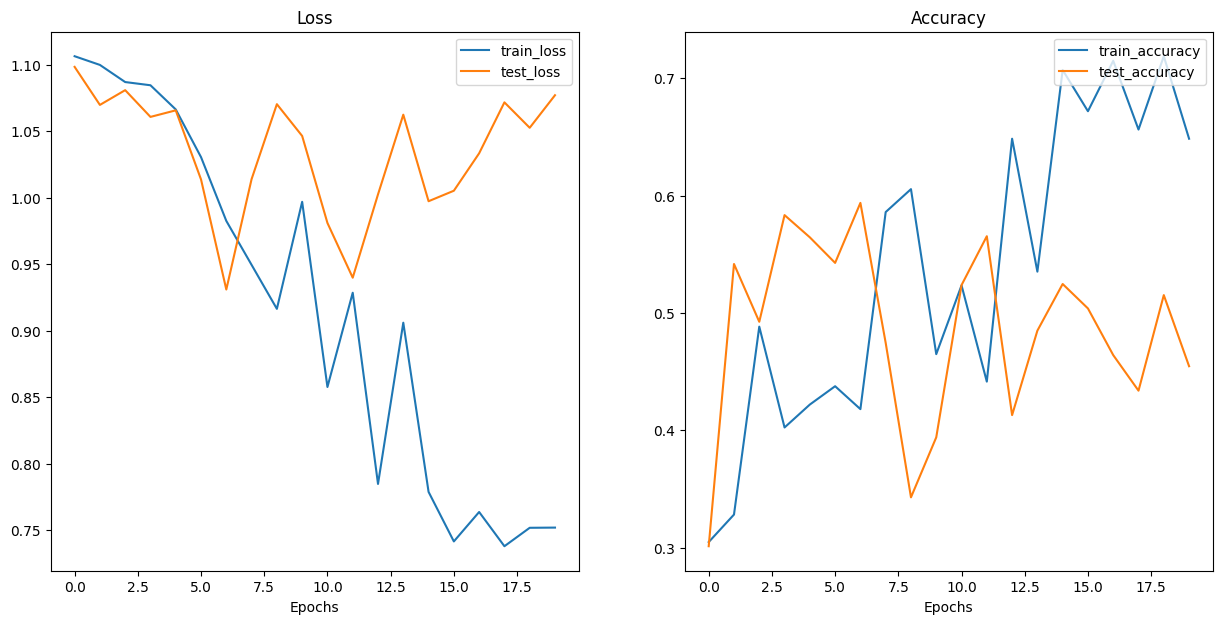

In [67]:
plot_loss_curves(model_0_results)

## 8. What should an ideal loss curve look like?

https://developers.google.com/machine-learning/crash-course/overfitting/interpreting-loss-curves

A loss curve is one of the most helpful ways to troubleshoot a model.

## 9. Model 1: Create TinyVGG with Data Augmentation

Now let's try another modelling experiment this time using the same model as before but with some data augmentation.

### 9.1 Create transform with data augmentation

In [68]:
# Create training transform with TrivialAugment
from torchvision import transforms
train_transform_trivial = transforms.Compose(
    [
        transforms.Resize(size = (64, 64)),
        transforms.TrivialAugmentWide(num_magnitude_bins=31),
        transforms.ToTensor()
    ]
)

# Create test transform with TrivialAugment
test_transform_simple = transforms.Compose(
    [
        transforms.Resize(size = (64, 64)),
        transforms.ToTensor()
    ]
)

### 9.2 Create train and test Dataset's and Dataloader's with data augmentation.

In [69]:
# Turn image folders into Datasets
from torchvision import datasets
train_data_augmented = datasets.ImageFolder(
    root = train_dir,
    transform = train_transform_trivial)

test_data_simple = datasets.ImageFolder(
    root = test_dir,
    transform = test_transform_simple)

In [70]:
# Turn out Datasets into DataLoaders
from torch.utils.data import DataLoader
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                        batch_size = BATCH_SIZE,
                                        shuffle = True,
                                        num_workers = NUM_WORKERS)

test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size = BATCH_SIZE,
                                    shuffle = False,
                                    num_workers = NUM_WORKERS)

### 9.3 Construct and train model 1

This time we'll be using the same model architecture except this time we've augmented the training data.

In [71]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_augmented.classes)).to(device)

Wonderful! No we've had a model and dataloader,s let's create a loss function and an optimizer and call upon our `train()` function to train and evaluate our model.

In [72]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
NUM_EPOCHS = 20

# Setup the loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(),
                             lr = 0.001)

# Start the timer
from timeit import default_timer
start_time = timer()

# Train model 1
model_1_results = train(model = model_1,
                        train_dataloader = train_dataloader_augmented,
                        test_dataloader = test_dataloader_simple,
                        optimizer = optimizer,
                        loss_fn = loss_fn,
                        epochs = NUM_EPOCHS,
                        device = device)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time - start_time:.3f} seconds")

  5%|▌         | 1/20 [00:01<00:32,  1.73s/it]

Epoch: 0 | train_loss: 1.1049 | train_acc: 0.2500 | test_loss: 1.1019 | test_acc: 0.2604


 10%|█         | 2/20 [00:04<00:45,  2.55s/it]

Epoch: 1 | train_loss: 1.0807 | train_acc: 0.4258 | test_loss: 1.1261 | test_acc: 0.2604


 15%|█▌        | 3/20 [00:06<00:39,  2.32s/it]

Epoch: 2 | train_loss: 1.0712 | train_acc: 0.4258 | test_loss: 1.1593 | test_acc: 0.2604


 20%|██        | 4/20 [00:08<00:34,  2.15s/it]

Epoch: 3 | train_loss: 1.1254 | train_acc: 0.3047 | test_loss: 1.1581 | test_acc: 0.2604


 25%|██▌       | 5/20 [00:10<00:30,  2.01s/it]

Epoch: 4 | train_loss: 1.0858 | train_acc: 0.4258 | test_loss: 1.1551 | test_acc: 0.3333


 30%|███       | 6/20 [00:12<00:27,  1.94s/it]

Epoch: 5 | train_loss: 1.0859 | train_acc: 0.3789 | test_loss: 1.1431 | test_acc: 0.2708


 35%|███▌      | 7/20 [00:13<00:22,  1.74s/it]

Epoch: 6 | train_loss: 1.0718 | train_acc: 0.5000 | test_loss: 1.1342 | test_acc: 0.3229


 40%|████      | 8/20 [00:14<00:18,  1.51s/it]

Epoch: 7 | train_loss: 1.0814 | train_acc: 0.3633 | test_loss: 1.1245 | test_acc: 0.3229


 45%|████▌     | 9/20 [00:16<00:16,  1.52s/it]

Epoch: 8 | train_loss: 1.0817 | train_acc: 0.4258 | test_loss: 1.0857 | test_acc: 0.3333


 50%|█████     | 10/20 [00:17<00:14,  1.44s/it]

Epoch: 9 | train_loss: 1.0042 | train_acc: 0.4375 | test_loss: 0.9595 | test_acc: 0.5445


 55%|█████▌    | 11/20 [00:18<00:11,  1.29s/it]

Epoch: 10 | train_loss: 0.9739 | train_acc: 0.5781 | test_loss: 0.9887 | test_acc: 0.3826


 60%|██████    | 12/20 [00:19<00:09,  1.17s/it]

Epoch: 11 | train_loss: 0.9522 | train_acc: 0.5859 | test_loss: 1.0242 | test_acc: 0.3930


 65%|██████▌   | 13/20 [00:20<00:07,  1.10s/it]

Epoch: 12 | train_loss: 0.9639 | train_acc: 0.5547 | test_loss: 1.0100 | test_acc: 0.3617


 70%|███████   | 14/20 [00:21<00:06,  1.05s/it]

Epoch: 13 | train_loss: 1.0042 | train_acc: 0.5312 | test_loss: 1.0579 | test_acc: 0.4034


 75%|███████▌  | 15/20 [00:22<00:05,  1.01s/it]

Epoch: 14 | train_loss: 0.9447 | train_acc: 0.5820 | test_loss: 1.0694 | test_acc: 0.4138


 80%|████████  | 16/20 [00:23<00:03,  1.02it/s]

Epoch: 15 | train_loss: 0.9580 | train_acc: 0.5547 | test_loss: 1.0762 | test_acc: 0.3939


 85%|████████▌ | 17/20 [00:23<00:02,  1.04it/s]

Epoch: 16 | train_loss: 1.0534 | train_acc: 0.4492 | test_loss: 1.0846 | test_acc: 0.3835


 90%|█████████ | 18/20 [00:24<00:01,  1.05it/s]

Epoch: 17 | train_loss: 0.9083 | train_acc: 0.5625 | test_loss: 1.0696 | test_acc: 0.3731


 95%|█████████▌| 19/20 [00:25<00:00,  1.05it/s]

Epoch: 18 | train_loss: 0.8740 | train_acc: 0.5820 | test_loss: 1.0679 | test_acc: 0.3523


100%|██████████| 20/20 [00:26<00:00,  1.34s/it]

Epoch: 19 | train_loss: 0.9361 | train_acc: 0.4570 | test_loss: 1.0365 | test_acc: 0.3513
Total training time: 26.776 seconds


In [73]:
!nvidia-smi

Wed Apr 30 20:57:26 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   63C    P0             30W /   70W |     208MiB /  15360MiB |      1%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

### 9.4 Plot the loss curves of model 1

A loss curve helps you evaluate your models performance over time.

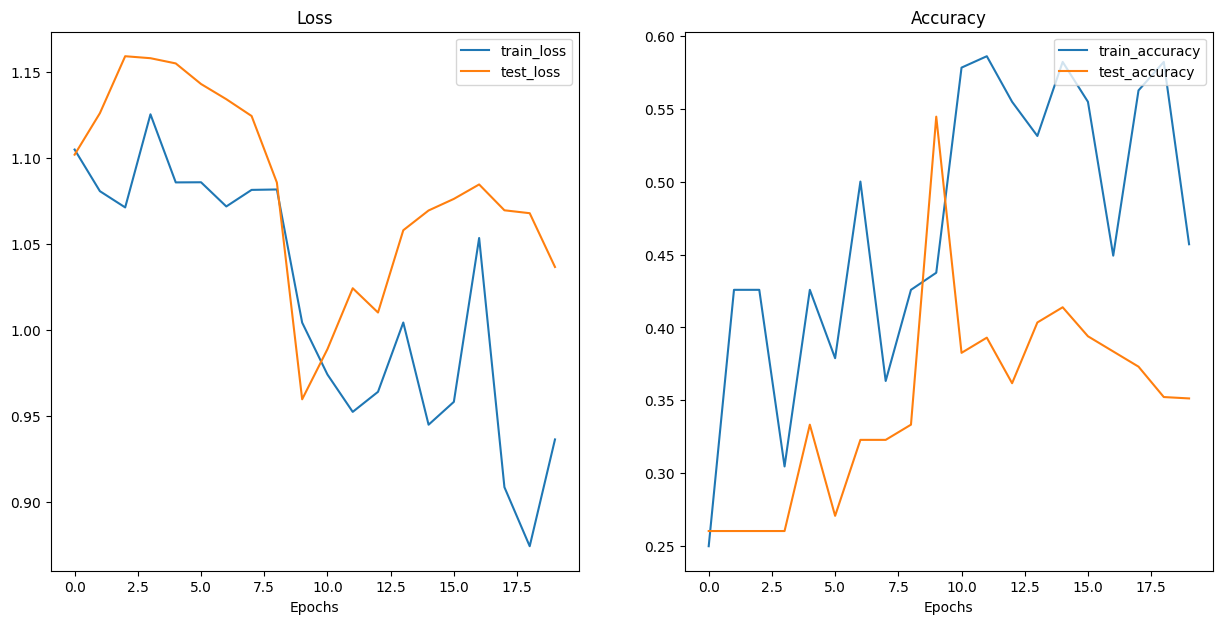

In [74]:
plot_loss_curves(model_1_results)

## 10. Compare model results

After evaluating our modelling experiments on their own, it's important to compare them to each other.

There's a few different ways to do this:
1. Hard coding it (what we're doing it)
2. Pytorch + tensorboard
3. Weights and Biases
4. MlFlow

In [75]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)
model_0_df

train_loss  train_acc  test_loss  test_acc
0     1.106319   0.304688   1.098322  0.301136
1     1.099783   0.328125   1.069723  0.541667
2     1.086905   0.488281   1.080821  0.492424
3     1.084495   0.402344   1.060716  0.583333
4     1.066325   0.421875   1.065643  0.564394
5     1.030464   0.437500   1.013698  0.542614
6     0.982545   0.417969   0.930984  0.593750
7     0.949502   0.585938   1.013973  0.474432
8     0.916445   0.605469   1.070277  0.342803
9     0.996906   0.464844   1.046388  0.393939
10    0.857716   0.523438   0.981000  0.523674
11    0.928568   0.441406   0.939861  0.565341
12    0.784857   0.648438   1.002488  0.412879
13    0.906033   0.535156   1.062381  0.484848
14    0.778885   0.707031   0.997338  0.524621
15    0.741657   0.671875   1.005224  0.503788
16    0.763780   0.714844   1.033355  0.464015
17    0.738050   0.656250   1.071645  0.433712
18    0.751901   0.718750   1.052543  0.515152
19    0.752048   0.648438   1.077011  0.454545

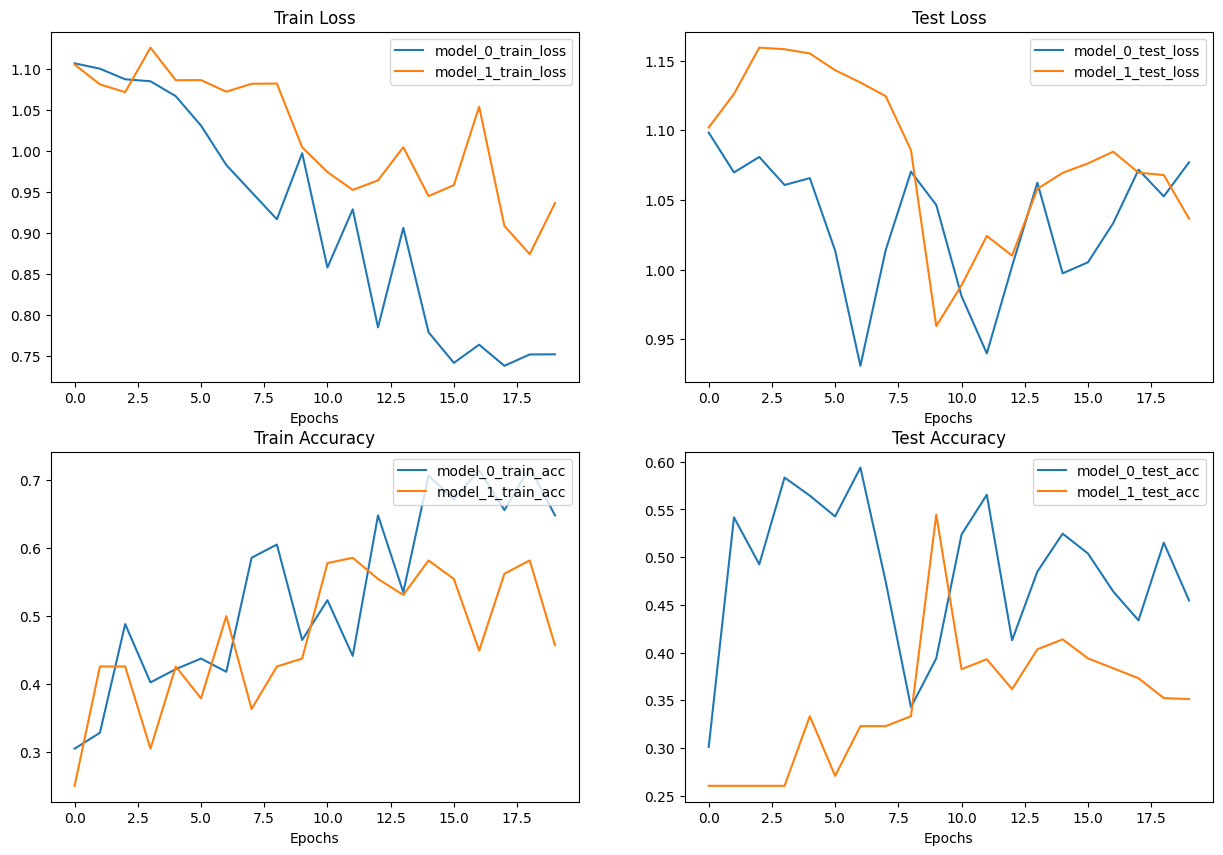

In [76]:
# Setup a plot
plt.figure(figsize=(15, 10))

# Get the number of epochs
epochs = range(len(model_0_df))

# Plot for the train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label = "model_0_train_loss")
plt.plot(epochs, model_1_df["train_loss"], label = "model_1_train_loss")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend(loc = "upper right")

plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label = "model_0_test_loss")
plt.plot(epochs, model_1_df["test_loss"], label = "model_1_test_loss")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend(loc = "upper right")

plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label = "model_0_train_acc")
plt.plot(epochs, model_1_df["train_acc"], label = "model_1_train_acc")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend(loc = "upper right")

plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label = "model_0_test_acc")
plt.plot(epochs, model_1_df["test_acc"], label = "model_1_test_acc")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend(loc = "upper right")

## 11. Making a prediction on a custom image

Althought we've trained a model on custom data... how do you make a prediciton on a sample/iamge that's not in either training or testing.

In [77]:
# Download custom image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesnt exist
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    # When downloading from GitHub, need to use the "raw" file link
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    print(f"Donwloading {custom_image_path}...")
    f.write(request.content)
else:
  print(f"{custom_image_path} already exists, skipping download")

Donwloading data/04-pizza-dad.jpeg...


### 11.1 Loading in a custom image with PyTorch

We have to make sure our custom imag eis in the same format as the data our model was trained on.

* In tensor from with datatype (torch.float32)
* Of Shape 64x64x3
* On the right device

We can read an image into PyTorch using -
https://pytorch.org/vision/stable/generated/torchvision.io.read_image.html


In [78]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(custom_image_path)
print(f"Custom image tensor: \n {custom_image_uint8}")
print(f"Custom image shape: {custom_image_uint8.shape}")
print(f"Custom image dtype: {custom_image_uint8.dtype}")

Custom image tensor: 
 tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)
Custom image shape: torch.Size([3, 4032, 3024])
Custom image dty

(np.float64(-0.5), np.float64(3023.5), np.float64(4031.5), np.float64(-0.5))

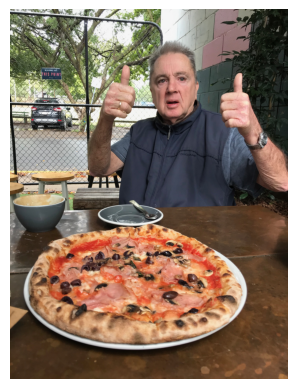

In [79]:
plt.imshow(custom_image_uint8.permute(1, 2, 0))
plt.axis("off")

### 11.2 Making a prediction on a custom image with a trained PyTorch model

In [81]:
# Load in the custom image and convert to torch.float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32) / 255.
print(f"Custom image shape: {custom_image.shape}")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image shape: torch.Size([3, 4032, 3024])
Custom image dtype: torch.float32


In [82]:
from torchvision import transforms

custom_image_transform = transforms.Compose(
    [
        transforms.Resize(size = (64, 64))
    ]
)

custom_image_transformed = custom_image_transform(custom_image)
print(f"Original image shape: {custom_image.shape}")
print(f"Custom image shape: {custom_image_transformed.shape}")

Original image shape: torch.Size([3, 4032, 3024])
Custom image shape: torch.Size([3, 64, 64])


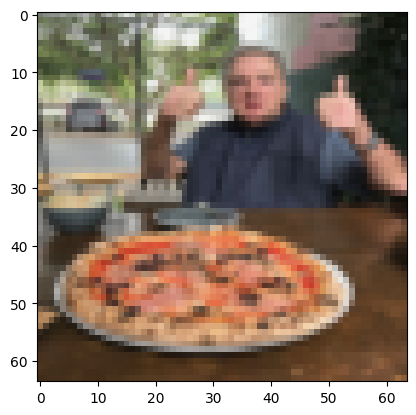

In [83]:
plt.imshow(custom_image_transformed.permute(1, 2, 0))

In [84]:
# Try to make a prediction on an image in uint8 format
# This will error no batch size
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.to(device).unsqueeze(dim = 0))

Note to make a prediction on a cusotm image we had to:
* Load the image and turn it into a tensor.
* Make sure the image was the same datatype as the model (torch.float32)
* Make sure the image was in the same shape as the data the model was trained on (3, 64, 64) with a batch size .. (1,3,64, 64)
* Make sure the image was one the same device as our model.

In [85]:
# Convert logits -> prediction probabilities -> prediction labels
class_names[torch.softmax(custom_image_pred, dim = 1).argmax(dim = 1)]

'pizza'

### 11.3 Putting custom image prediction together: building a function

Ideal outcome:

A function where we pass an image path to and have our model predict on that image and plot the image plus the prediction.

In [86]:
def pred_and_plot_images(model: torch.nn.Module,
                         image_path: str,
                         class_names: List[str] = None,
                         transform = None,
                         device = device):
  '''
  Makes a prediction on a target image with a trained model
  and plots the image and prediction.
  '''
  # Load the image
  target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

  # Divide the image pixel values by 255 to get them between 0 and 1
  target_image = target_image / 255.

  # Transform if necessary
  if transform:
    target_image = transform(target_image)

  # Make sure the model is on the target device
  model.to(device)

  # Make a prediciton
  model.eval()
  with torch.inference_mode():
    # Add an extra dimension to the image (this is the batch image, e.g. our model will predict on batches)
    target_image_logits = model(target_image.unsqueeze(dim = 0).to(device))

  # Convert logits -> probs
  target_image_pred_probs = torch.softmax(target_image_logits, dim = 1)

  # Convert probs -> predicted labels
  target_image_pred_labels = target_image_pred_probs.argmax(dim = 1)

  # Plot the image alongisde the prediction and prediction probability
  plt.imshow(target_image.squeeze().permute(1, 2, 0)) # remove batch dimension and rearrange it to HWC

  if class_names:
    title = f"Pred: {class_names[target_image_pred_labels.cpu()]} | Prob: {target_image_pred_probs.max():.3f}"
  else:
    title = f"Pred: {target_image_pred_labels}  | Prob: {target_image_pred_probs.max():.3f}"
  plt.title(title)
  plt.show()


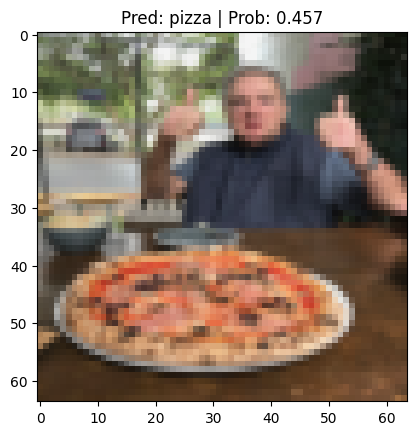

In [87]:
# Pred on our custom image
pred_and_plot_images(model=model_1,
                     image_path=custom_image_path,
                     class_names=class_names,
                     transform=custom_image_transform,
                     device = device)